In [7]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

Pkg.add("MathOptInterface")
Pkg.add("Ipopt")
Pkg.add("ForwardDiff")
Pkg.add("Convex") 
Pkg.add("ECOS")
Pkg.add("JLD2")
Pkg.add("Plots")

import MathOptInterface as MOI
import Ipopt 
import ForwardDiff as FD 
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc 
using Printf

  Activating environment at `~/tiltrotor_control/Project.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


In [8]:
include(joinpath(@__DIR__, "tiltrotor_dynamics.jl"))

function discrete_dynamics(params::NamedTuple, x::Vector, u, k)
    # discrete dynamics
    # x - state 
    # u - control 
    # k - index of trajectory 
    # dt comes from params.model.dt 
    return rk4(params.model, tiltrotor_dynamics_mrp, x, u, params.model.dt)
end

discrete_dynamics (generic function with 1 method)

## iLQR for a tiltrotor (25 pts)

iLQR is used to solve optimal control problems of the following form:
$$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \bigg[ \sum_{i=1}^{N-1} \ell(x_i,u_i)\bigg] + \ell_N(x_N)\\ 
 \text{st} \quad & x_1 = x_{{IC}} \\ 
 & x_{k+1} = f(x_k, u_k) \quad \text{for } i = 1,2,\ldots,N-1 \\
 \end{align}$$
 where $x_{IC}$ is the inital condition, $x_{k+1} = f(x_k, u_k)$ is the discrete dynamics function, $\ell(x_i,u_i)$ is the stage cost, and $\ell_N(x_N)$ is the terminal cost.  Since this optimization problem can be non-convex, there is no guarantee of convergence to a global optimum, or even convergene rates to a local optimum, but in practice we will see that it can work very well. 
 
For this problem, we are going to use a simple cost function consisting of the following stage cost:

$$ \ell(x_i,u_i) = \frac{1}{2} (x_i - x_{ref,i})^TQ(x_i - x_{ref,i}) + \frac{1}{2}(u_i - u_{ref,i})^TR(u_i - u_{ref,i}) $$

And the following terminal cost:

$$ \ell_N(x_N) = \frac{1}{2}(x_N - x_{ref,N})^TQ_f(x_N - x_{ref,N}) $$

This is how we will encourange our tiltrotor to track a reference trajectory $x_{ref}$. We will consider iLQR to have converged when $\Delta J < \text{atol}$ as calculated during the backwards pass. 

In [9]:
function stage_cost(p::NamedTuple,x::Vector,u::Vector,k::Int)
    return 0.5*(x-p.Xref[k])'*p.Q*(x-p.Xref[k]) + 0.5*(u-p.Uref[k])'*p.R*(u-p.Uref[k])
end

function term_cost(p::NamedTuple,x)
    return 0.5*(x-p.Xref[p.N])'*p.Qf*(x-p.Xref[p.N])
end

function stage_cost_expansion(p::NamedTuple, x::Vector, u::Vector, k::Int)
    return FD.hessian(x->stage_cost(p,x,u,k),x), FD.gradient(x->stage_cost(p,x,u,k),x), FD.hessian(u->stage_cost(p,x,u,k),u), FD.gradient(u->stage_cost(p,x,u,k),u)
end

function term_cost_expansion(p::NamedTuple, x::Vector)
    return FD.hessian(x->term_cost(p,x),x), FD.gradient(x->term_cost(p,x),x)
end

function trajectory_cost(params::NamedTuple,    # params 
    X::Vector{Vector{Float64}},                 # state trajectory 
    U::Vector{Vector{Float64}})                 # control trajectory 
    
    N = params.N

    J = 0.0
    for i = 1:N-1
    J += stage_cost(params, X[i], U[i], i)
    end
    J += term_cost(params, X[N])
    return J
end

function backward_pass(params::NamedTuple,          # useful params 
                       X::Vector{Vector{Float64}},  # state trajectory 
                       U::Vector{Vector{Float64}})  # control trajectory 
    # compute the iLQR backwards pass given a dynamically feasible trajectory X and U
    # return d, K, ΔJ  
    
    # outputs:
    #     d  - Vector{Vector} feedforward control  
    #     K  - Vector{Matrix} feedback gains 
    #     ΔJ - Float64        expected decrease in cost 
    
    nx, nu, N = params.nx, params.nu, params.N 

    # vectors of vectors/matrices for recursion 
    P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
    p = [zeros(nx)    for i = 1:N]   # cost to go linear term
    d = [zeros(nu)    for i = 1:N-1] # feedforward control
    K = [zeros(nu,nx) for i = 1:N-1] # feedback gain
    
    Qf = params.Qf
    Q = params.Q
    R = params.R
    Xref = params.Xref
    Uref = params.Uref
    
    ΔJ = 0.0
    p[N] .= Qf*(X[N]-Xref[N])
    P[N] .= Qf

    for k = N-1:-1:1
        
        #Calculate derivatives
        q = Q*(X[k]-Xref[k])
        r = R*(U[k]-Uref[k])
    
        A = FD.jacobian(dx->discrete_dynamics(params, dx, U[k], k),X[k])
        B = FD.jacobian(du->discrete_dynamics(params, X[k], du, k),U[k])
        
        gx = q + A'*p[k+1]
        gu = r + B'*p[k+1]
    
        #iLQR (Gauss-Newton) version
        Gxx = Q + A'*P[k+1]*A
        Guu = R + B'*P[k+1]*B
        Gxu = A'*P[k+1]*B
        Gux = B'*P[k+1]*A
        
        # Regularization
        β = 0.1
        while !isposdef(Symmetric([Gxx Gxu; Gux Guu]))
            Gxx += A'*β*I*A
            Guu += B'*β*I*B
            Gxu += A'*β*I*B
            Gux += B'*β*I*A
            β = 2*β
        end
        
        # Calculate d and K
        d[k] = Guu\gu
        K[k] .= Guu\Gux
    
        # Update p and P
        p[k] .= gx - K[k]'*gu + K[k]'*Guu*d[k] - Gxu*d[k]
        P[k] .= Gxx + K[k]'*Guu*K[k] - Gxu*K[k] - K[k]'*Gux
    
        ΔJ += gu'*d[k]
    end

    return d, K, ΔJ
end

function forward_pass(params::NamedTuple,           # useful params 
                      X::Vector{Vector{Float64}},   # state trajectory 
                      U::Vector{Vector{Float64}},   # control trajectory 
                      d::Vector{Vector{Float64}},   # feedforward controls 
                      K::Vector{Matrix{Float64}};   # feedback gains
                      max_linesearch_iters = 20)    # max iters on linesearch 
    # forward pass in iLQR with linesearch 
    # use a line search where the trajectory cost simply has to decrease (no Armijo)
    
    # outputs:
    #     Xn::Vector{Vector}  updated state trajectory  
    #     Un::Vector{Vector}  updated control trajectory 
    #     J::Float64          updated cost  
    #     α::Float64.         step length 

    nx, nu, N = params.nx, params.nu, params.N 
    
    Xn = [zeros(nx) for i = 1:N]      # new state history 
    Un = [zeros(nu) for i = 1:N-1]    # new control history 
    
    # initial condition 
    Xn[1] = 1*X[1]
    
    # initial step length 
    α = 1.0
    
    # forward pass 
    J = trajectory_cost(params, X, U)
    for i = 1:max_linesearch_iters
        for k = 1:N-1
            Un[k] = U[k] - α*d[k] - K[k]*(Xn[k]-X[k])
            Xn[k+1] .= discrete_dynamics(params, Xn[k], Un[k], k)
        end
        Jn = trajectory_cost(params, Xn, Un)
        α = 0.5*α

        if Jn < J
            return Xn, Un, Jn, α
        end
    end

    error("forward pass failed")
end

forward_pass (generic function with 1 method)

In [10]:
function iLQR(params::NamedTuple,         # useful params for costs/dynamics/indexing 
              x0::Vector,                 # initial condition 
              U::Vector{Vector{Float64}}; # initial controls 
              atol=1e-3,                  # convergence criteria: ΔJ < atol 
              max_iters = 250,            # max iLQR iterations 
              verbose = true)             # print logging
    
    # iLQR solver given an initial condition x0, initial controls U, and a 
    # dynamics function described by `discrete_dynamics`
    
    # return (X, U, K) where 
    # outputs:
    #     X::Vector{Vector} - state trajectory 
    #     U::Vector{Vector} - control trajectory 
    #     K::Vector{Matrix} - feedback gains K 

    # first check the sizes of everything
    @assert length(U) == params.N-1
    @assert length(U[1]) == params.nu
    @assert length(x0) == params.nx 

    nx, nu, N = params.nx, params.nu, params.N

    # initial rollout
    X = [zeros(nx) for i = 1:N]
    X[1] .= 1*x0
    for k = 1:N-1
        X[k+1] .= discrete_dynamics(params, X[k], U[k], k)
    end

    for ilqr_iter = 1:max_iters

        d, K, ΔJ = backward_pass(params, X, U)
        X, U, J, α = forward_pass(params, X, U, d, K)
        
        # termination criteria 
        if ΔJ < atol 
            if verbose 
                @info "iLQR converged"
            end
            return X, U, K 
        end
        
        # ---------------logging -------------------
        if verbose
            dmax = maximum(norm.(d))
            if rem(ilqr_iter-1,10)==0
                @printf "iter     J           ΔJ        |d|         α         \n"
                @printf "-------------------------------------------------\n"
            end
            @printf("%3d   %10.3e  %9.2e  %9.2e  %6.4f    \n",
              ilqr_iter, J, ΔJ, dmax, α)
        end
        
    end
    error("iLQR failed")
end

iLQR (generic function with 1 method)

In [11]:
# function create_reference(N, dt)
#     # create reference trajectory for quadrotor 
#     R = 6
#     Xref = [ [R*cos(t);R*cos(t)*sin(t);1.2 + sin(t);zeros(9)] for t = range(-pi/2,3*pi/2, length = N)]
#     for i = 1:(N-1)
#         Xref[i][4:6] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
#     end
#     Xref[N][4:6] = Xref[N-1][4:6]
#     uhover = ((9.81*0.5/2))*ones(4)
#     uhover[3] = 0.0
#     uhover[4] = 0.0
#     Uref = [uhover for i = 1:(N-1)]
#     return Xref, Uref
# end

function create_reference(params, N, dt)
    # create reference trajectory for tiltrotor 
    M = floor(Int, N/2)
    Xref = [[0;0;i/M;zeros(11)] for i = 1:N]
    for i = M+1:N
        Xref[i] = [(i-M-1)/N;0;1;zeros(11)]
    end
    for i = 1:(N-1)
        Xref[i][4:6] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
    end
    Xref[N][4:6] = Xref[N-1][4:6]
    uhover = ((9.81*params.mass/2)/params.kf)*ones(4)
    uhover[3] = 0.0
    uhover[4] = 0.0
    Uref = [uhover for i = 1:(N-1)]
    return Xref, Uref
end

create_reference (generic function with 1 method)

In [15]:
function solve_tiltrotor_trajectory(;verbose = true)
    
    # problem size 
    nx = 14
    nu = 4
    dt = 0.05 
    tf = 10
    t_vec = 0:dt:tf
    N = length(t_vec)

    # dynamics parameters (these are estimated)
    model = (
        mass=0.5,
        J=Diagonal([0.0023, 0.0023, 0.004]),
        gravity=[0,0,-9.81],
        L=0.1750,
        kf=1.0,
        km=0.0245,
        kδ=1.0,
        S_wing=0.05,
        ρ = 1.225,
        dt = dt
        )

    # create reference trajectory 
    Xref, Uref = create_reference(model, N, dt)

    # tracking cost function
    Q = 1*diagm([1*ones(3);.1*ones(3);1*ones(3);.1*ones(3);.1*ones(2)])
    R = .1*diagm(ones(nu))
    Qf = 10*Q 

    # the params needed by iLQR 
    params = (
        N = N, 
        nx = nx, 
        nu = nu, 
        Xref = Xref, 
        Uref = Uref, 
        Q = Q, 
        R = R, 
        Qf = Qf, 
        model = model
    )

    # initial condition 
    x0 = 1*Xref[1]
    
    # initial guess controls 
    U = [(uref + .0001*randn(nu)) for uref in Uref]
    
    # solve with iLQR
    X, U, K = iLQR(params,x0,U;atol=1e-4,max_iters = 250,verbose = verbose)
    
    return X, U, K, t_vec, params
end

solve_tiltrotor_trajectory (generic function with 1 method)

iter     J           ΔJ        |d|         α         
-------------------------------------------------


  1    1.710e+01   4.51e+02   1.06e+01  0.5000    
  2    4.279e-01   3.39e+01   3.83e+00  0.5000    


  3    1.079e-02   8.35e-01   5.55e-01  0.5000    
  4    1.023e-02   1.12e-03   2.57e-02  0.5000    


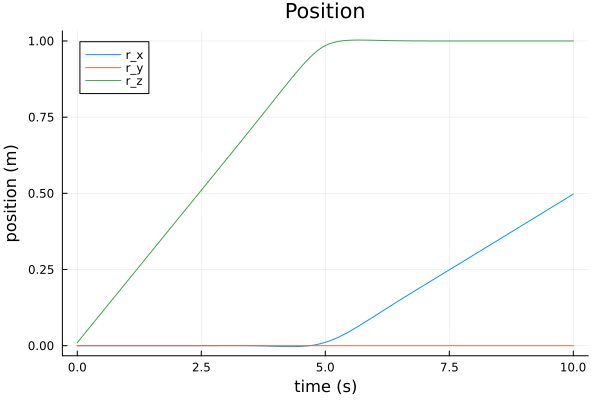

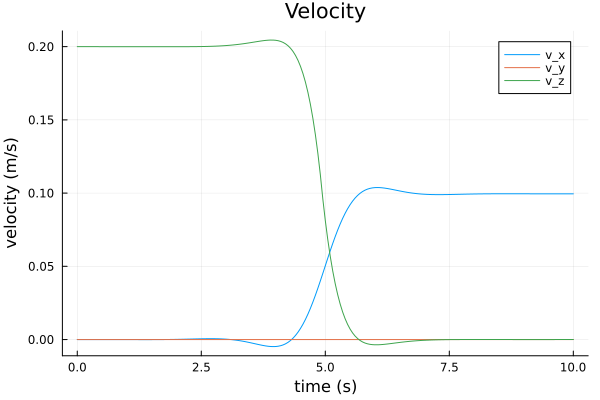

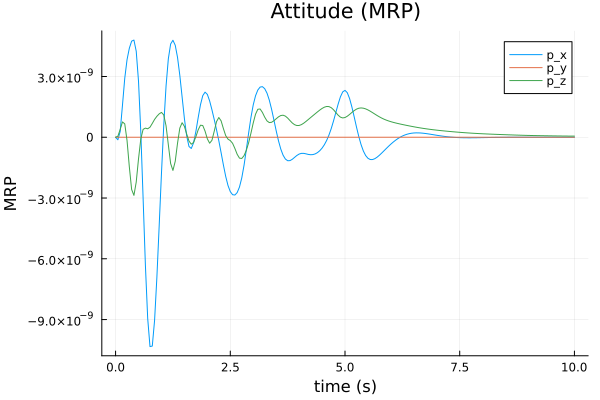

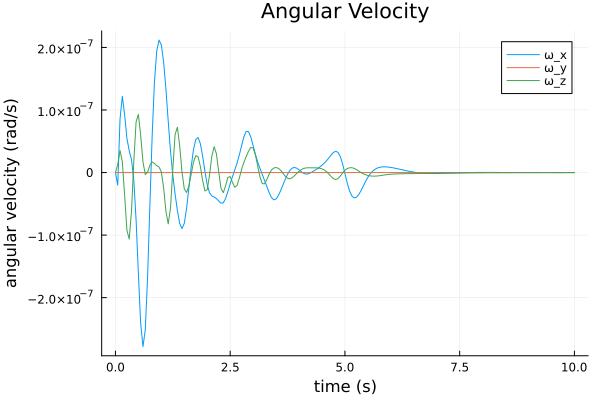

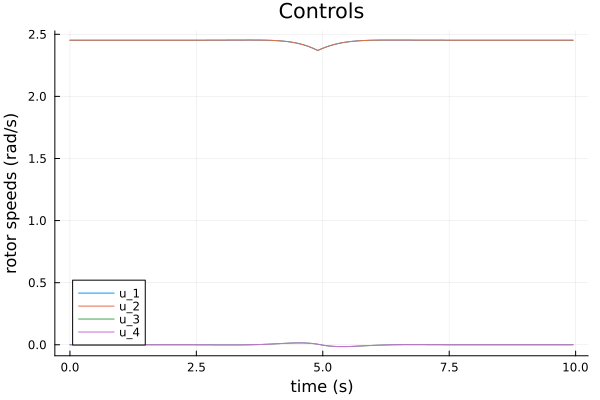

┌ Info: iLQR converged
└ @ Main /home/hariharan/tiltrotor_control/LQR.ipynb:39


In [16]:
Xilqr, Uilqr, Kilqr, t_vec, params =  solve_tiltrotor_trajectory(verbose = true)

# ---------------plotting------------------
Xm = hcat(Xilqr...)
Um = hcat(Uilqr...)
display(plot(t_vec, Xm[1:3,:]', xlabel = "time (s)", ylabel = "position (m)",
                                title = "Position", label = ["r_x" "r_y" "r_z"]))
display(plot(t_vec, Xm[4:6,:]', xlabel = "time (s)", ylabel = "velocity (m/s)",
                                title = "Velocity", label = ["v_x" "v_y" "v_z"]))
display(plot(t_vec, Xm[7:9,:]', xlabel = "time (s)", ylabel = "MRP",
                                title = "Attitude (MRP)", label = ["p_x" "p_y" "p_z"]))
display(plot(t_vec, Xm[10:12,:]', xlabel = "time (s)", ylabel = "angular velocity (rad/s)",
                                title = "Angular Velocity", label = ["ω_x" "ω_y" "ω_z"]))
display(plot(t_vec[1:end-1], Um', xlabel = "time (s)", ylabel = "rotor speeds (rad/s)",
                                title = "Controls", label = ["u_1" "u_2" "u_3" "u_4"]))

## Tracking solution with TVLQR

Here we take a trajectory from a trajectory optimization solver, and track it with TVLQR to account for some model mismatch.

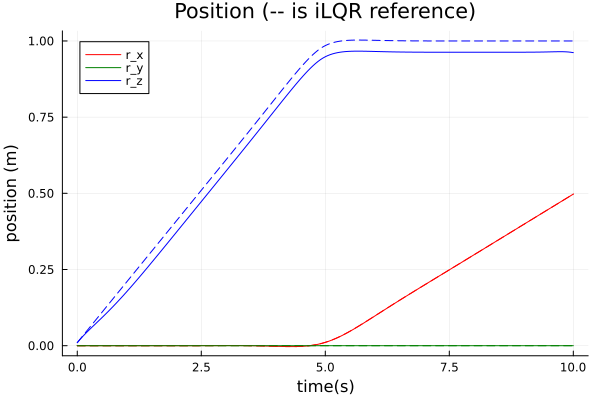

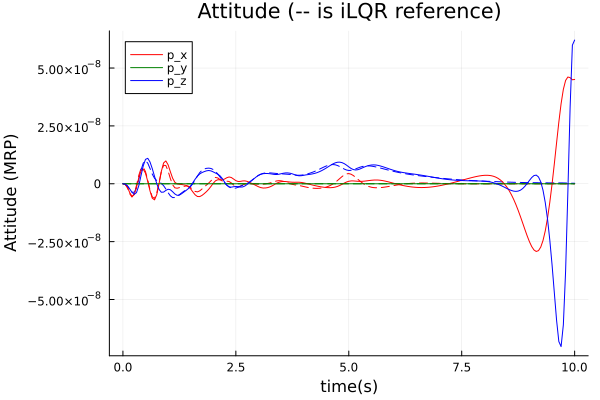

In [23]:
Xilqr, Uilqr, Kilqr, t_vec, params =  solve_tiltrotor_trajectory(verbose = false)

# real model parameters for dynamics 
model_real = (
        mass=0.52,
        J=Diagonal([0.0025, 0.002, 0.0045]),
        gravity=[0,0,-9.81],
        L=0.1550,
        kf=1.01,
        km=0.0365,
        kδ=0.99,
        S_wing=0.052,
        ρ = 1.225,
        dt = 0.05,
        )

# simulate closed loop system 
nx, nu, N = params.nx, params.nu, params.N
Xsim = [zeros(nx) for i = 1:N]
Usim = [zeros(nx) for i = 1:(N-1)]

# initial condition 
Xsim[1] = 1*Xilqr[1]

# simulate with closed loop control 
for i = 1:(N-1) 
    Usim[i] = -Kilqr[i]*(Xsim[i]-Xilqr[i]) + Uilqr[i]
    Xsim[i+1] = rk4(model_real, tiltrotor_dynamics_mrp, Xsim[i], Usim[i], model_real.dt)
end

# -----------------plotting---------------------
Xm = hcat(Xsim...)
Um = hcat(Usim...)
Xilqrm = hcat(Xilqr...)
Uilqrm = hcat(Uilqr...)
plot(t_vec,Xilqrm[1:3,:]',ls=:dash, label = "",lc = [:red :green :blue])
display(plot!(t_vec,Xm[1:3,:]',title = "Position (-- is iLQR reference)",
                xlabel = "time(s)", ylabel = "position (m)",
                label = ["r_x" "r_y" "r_z"],lc = [:red :green :blue]))

plot(t_vec,Xilqrm[7:9,:]',ls=:dash, label = "",lc = [:red :green :blue])
display(plot!(t_vec,Xm[7:9,:]',title = "Attitude (-- is iLQR reference)",
                xlabel = "time(s)", ylabel = "Attitude (MRP)",
                label = ["p_x" "p_y" "p_z"],lc = [:red :green :blue]))